# Social Network Ads Classifier

# Imports

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

# Functions

In [55]:
def check_for_nulls_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Nulls: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(df, y, axis):
  
  fig, ax = plt.subplots(figsize=(15,12))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_xlabel("Metrics")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance")
  ax.grid(True)
  ax.legend(y)
  plt.xticks(rotation=45)
  plt.show()
  
def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVC": SVC(class_weight="balanced"),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(class_weight="balanced"),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "ADASYN": ADASYN(),
    "KNN-SMOTE": SMOTE(k_neighbors=5),
    "SMOTE-T": SMOTETomek(),
    "SMOTENN": SMOTEENN()
  }
  
  return [models[model] for model in model_names]

def create_preprocessor_pipeline(numeric_features, categorical_features):
  
  numeric_features_cols = numeric_features.columns
  categorical_features_cols = categorical_features.columns
  
  numeric_transformer = sklearnPipeline(
    steps=[
      ("Scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  categorical_transformer = sklearnPipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  preprocessor = ColumnTransformer(
    transformers=[
      ("num", numeric_transformer, numeric_features_cols),
      ("cat", categorical_transformer, categorical_features_cols)
    ]
  )
  
  return preprocessor

def create_sklearn_pipeline(preprocessor, model_name, model):
  
  return sklearnPipeline(steps=[
    ("preprocessor", preprocessor),
    (model_name, model)
  ])

def evaluate_model(X, y, model, scoring_metric):
  
  cv = RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42)
  scores = cross_val_score(model, X, y, cv=cv, scoring=scoring_metric, n_jobs=-1)
  predictions = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
  
  acc = accuracy_score(y, predictions)
  f1_metric = f1_score(y, predictions, average="weighted")
  recall_metric = recall_score(y, predictions)
  precision_metric = precision_score(y, predictions)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(f1_metric, 3), 
    round(recall_metric,3),
    round(precision_metric,3),
  ]

def test_selected_models(model_names, models, preprocessor, X, y, scoring_metric):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model_name, model)
    scores = evaluate_model(X, y, pipeline, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "F1-Score":scores[4],
      "recall-Score":scores[5],
      "precision-Score":scores[5],
    })
  
  df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(df, ["Mean", "Var", "STD", "Test-Acc", "F1-Score", "recall-Score", "precision-Score"], "Metrics")
  print(df)

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/ads.csv")
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


# Check For Nulls And Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Nulls: User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64
The amount of Nulls: 0


# Check For Class Imbalance

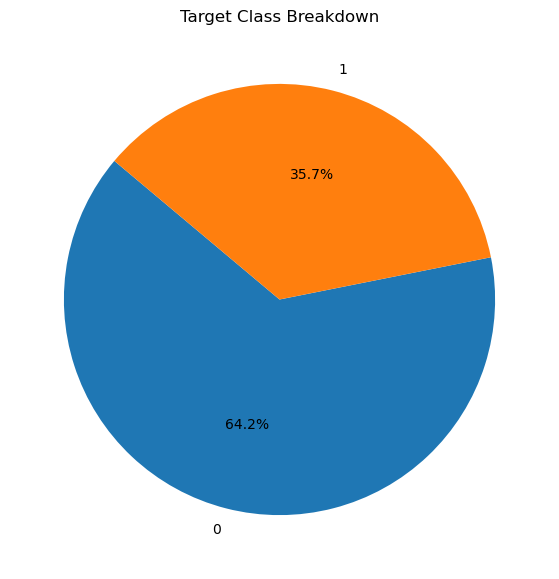

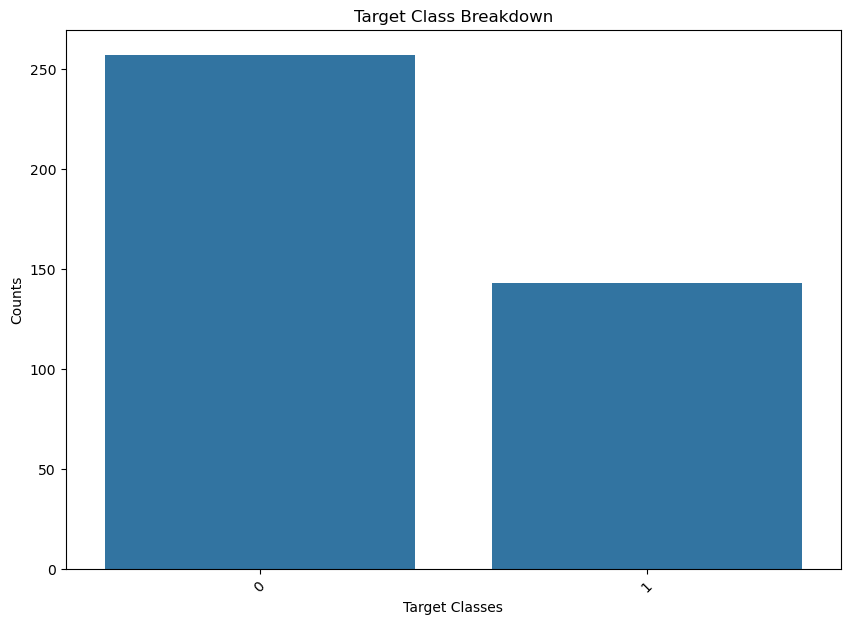

In [8]:
check_class_imbalance(df["Purchased"])

# We do have a class imbalance that will need to be addressed in our analysis.

In [9]:
df.dtypes

User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

In [10]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


# Drop uneeded column

In [11]:
df = df.drop("User ID", axis=1)

# Visuals

<AxesSubplot:>

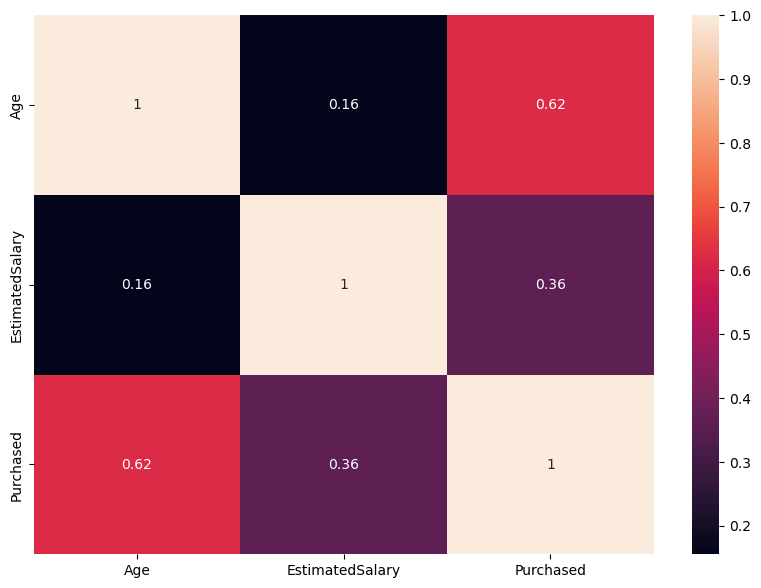

In [15]:
plt.figure(figsize=(10, 7))
relations = df.drop("Gender", axis=1).corr()
sns.heatmap(data=relations, annot=True)

<AxesSubplot:xlabel='Age', ylabel='EstimatedSalary'>

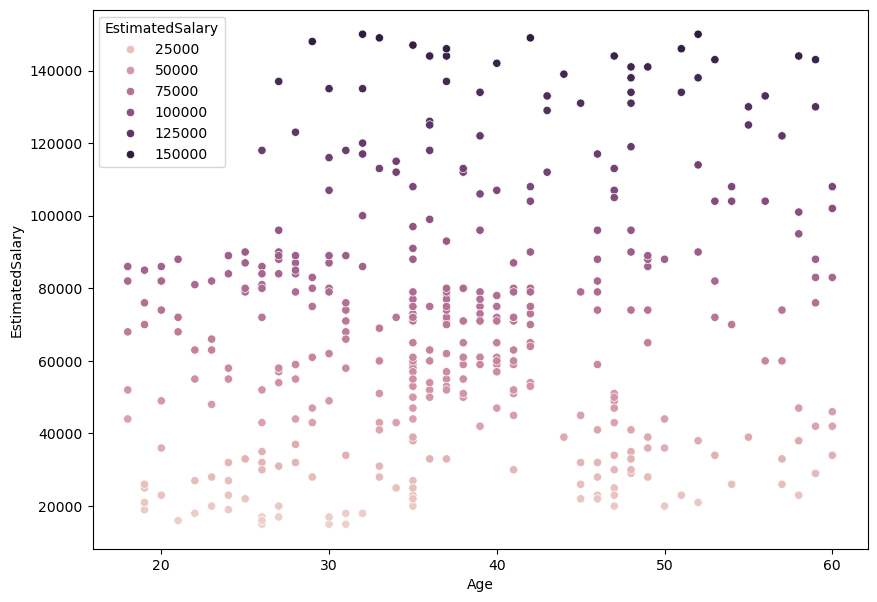

In [17]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="Age", y="EstimatedSalary", hue="EstimatedSalary")

<AxesSubplot:xlabel='Purchased', ylabel='EstimatedSalary'>

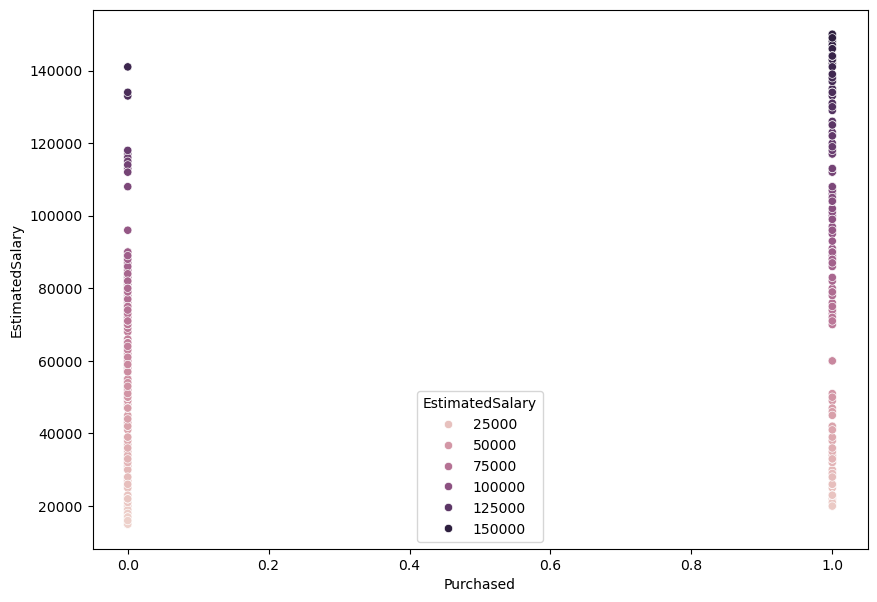

In [18]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="Purchased", y="EstimatedSalary", hue="EstimatedSalary")

<AxesSubplot:xlabel='Purchased', ylabel='Age'>

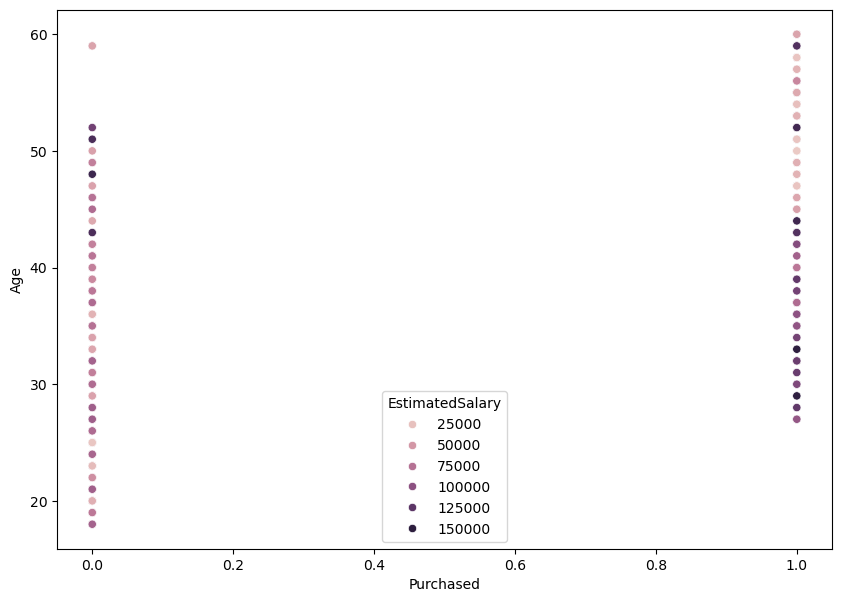

In [19]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="Purchased", y="Age", hue="EstimatedSalary")

# Create Metrics to Test

In [28]:
f1_metric = make_scorer(f1_score, average="weighted", greater_is_better=True)
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
recall_metric = make_scorer(recall_score, greater_is_better=True)
precision_metric = make_scorer(precision_score, greater_is_better=True)

# Separate Numric and Categorical features

In [43]:
numeric_features, categorical_features = df.select_dtypes(include="int64").drop("Purchased", axis=1), df.select_dtypes(include="object")

# Create Our Preprocessor Object

In [44]:
preprocessor = create_preprocessor_pipeline(numeric_features, categorical_features)

# Separate Features

In [45]:
X, y = df.drop("Purchased", axis=1), df["Purchased"]

# Create Baseline Model

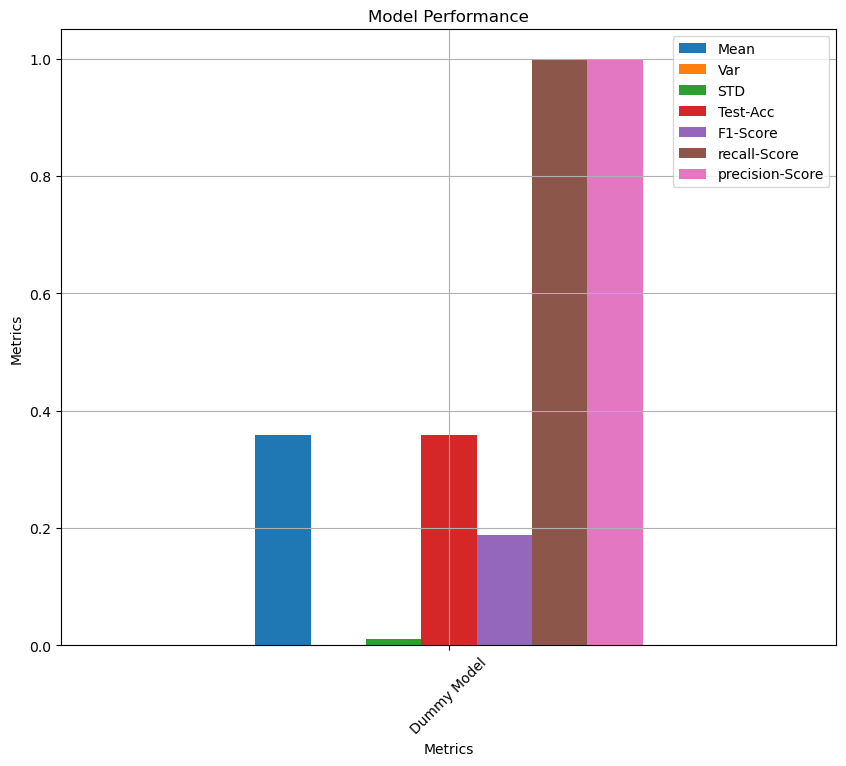

   index        Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy Model  0.358  0.0  0.011     0.358     0.188           1.0   

   precision-Score  
0              1.0  


In [46]:
model = DummyClassifier(strategy="constant", constant=1)

test_selected_models(["Dummy Model"], [model], preprocessor, X, y, acc_metric)

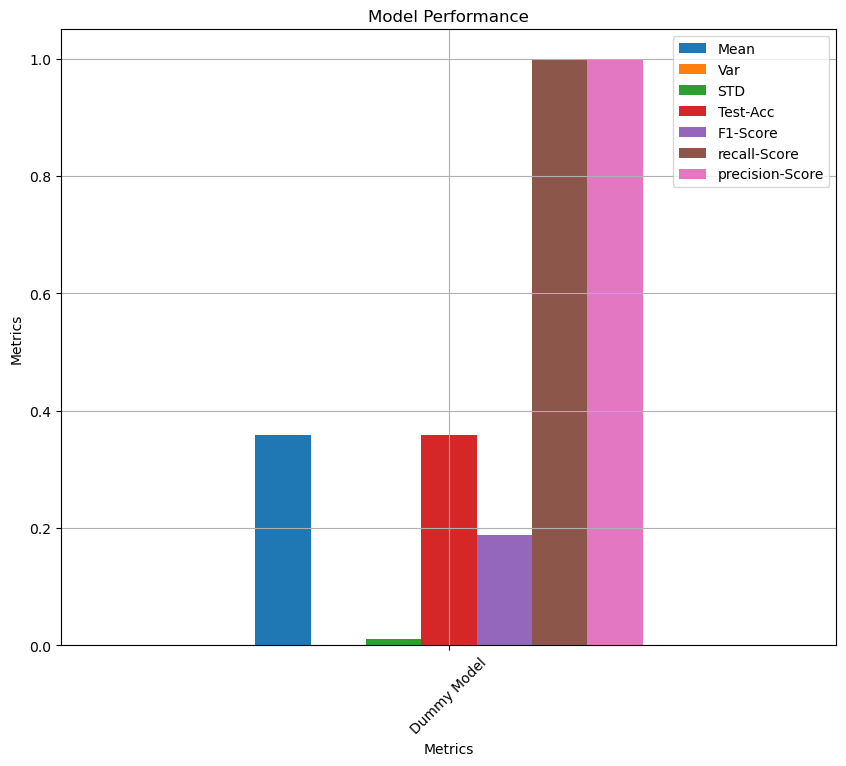

   index        Model   Mean  Var    STD  Test-Acc  F1-Score  recall-Score  \
0      0  Dummy Model  0.358  0.0  0.011     0.358     0.188           1.0   

   precision-Score  
0              1.0  


In [47]:
model = DummyClassifier(strategy="constant", constant=1)

test_selected_models(["Dummy Model"], [model], preprocessor, X, y, precision_metric)

# Advanced Model Metrics tested on different scoring metrics

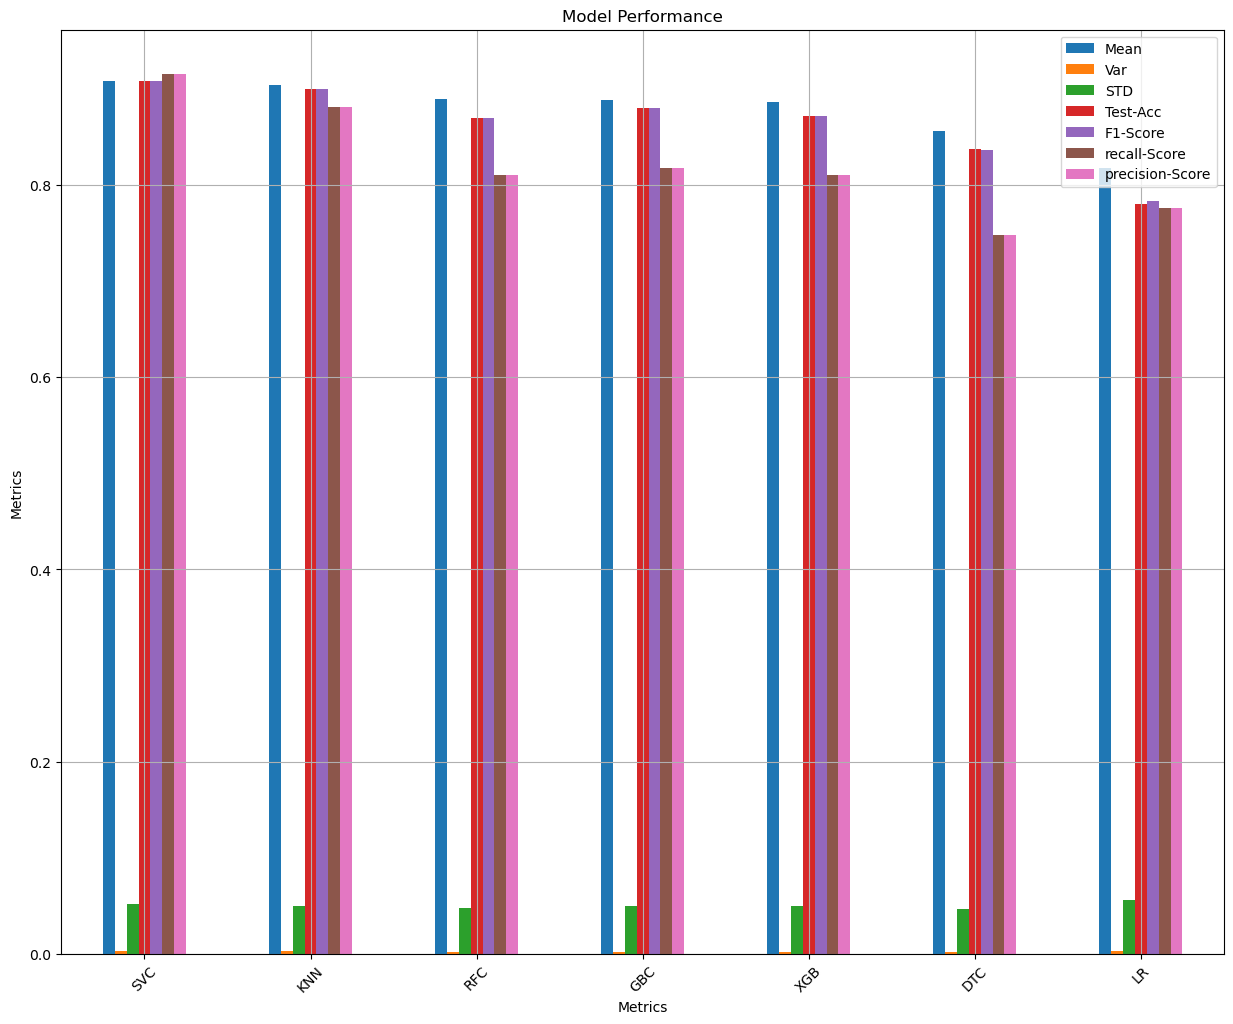

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      1   SVC  0.908  0.003  0.052     0.908     0.908         0.916   
1      2   KNN  0.904  0.003  0.050     0.900     0.900         0.881   
2      3   RFC  0.890  0.002  0.048     0.870     0.870         0.811   
3      6   GBC  0.889  0.002  0.050     0.880     0.880         0.818   
4      5   XGB  0.887  0.002  0.050     0.872     0.872         0.811   
5      4   DTC  0.856  0.002  0.047     0.838     0.837         0.748   
6      0    LR  0.818  0.003  0.056     0.780     0.783         0.776   

   precision-Score  
0            0.916  
1            0.881  
2            0.811  
3            0.818  
4            0.811  
5            0.748  
6            0.776  


In [50]:
model_names = ["LR", "SVC", "KNN", "RFC", "DTC", "XGB", "GBC"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, preprocessor, X, y, acc_metric)

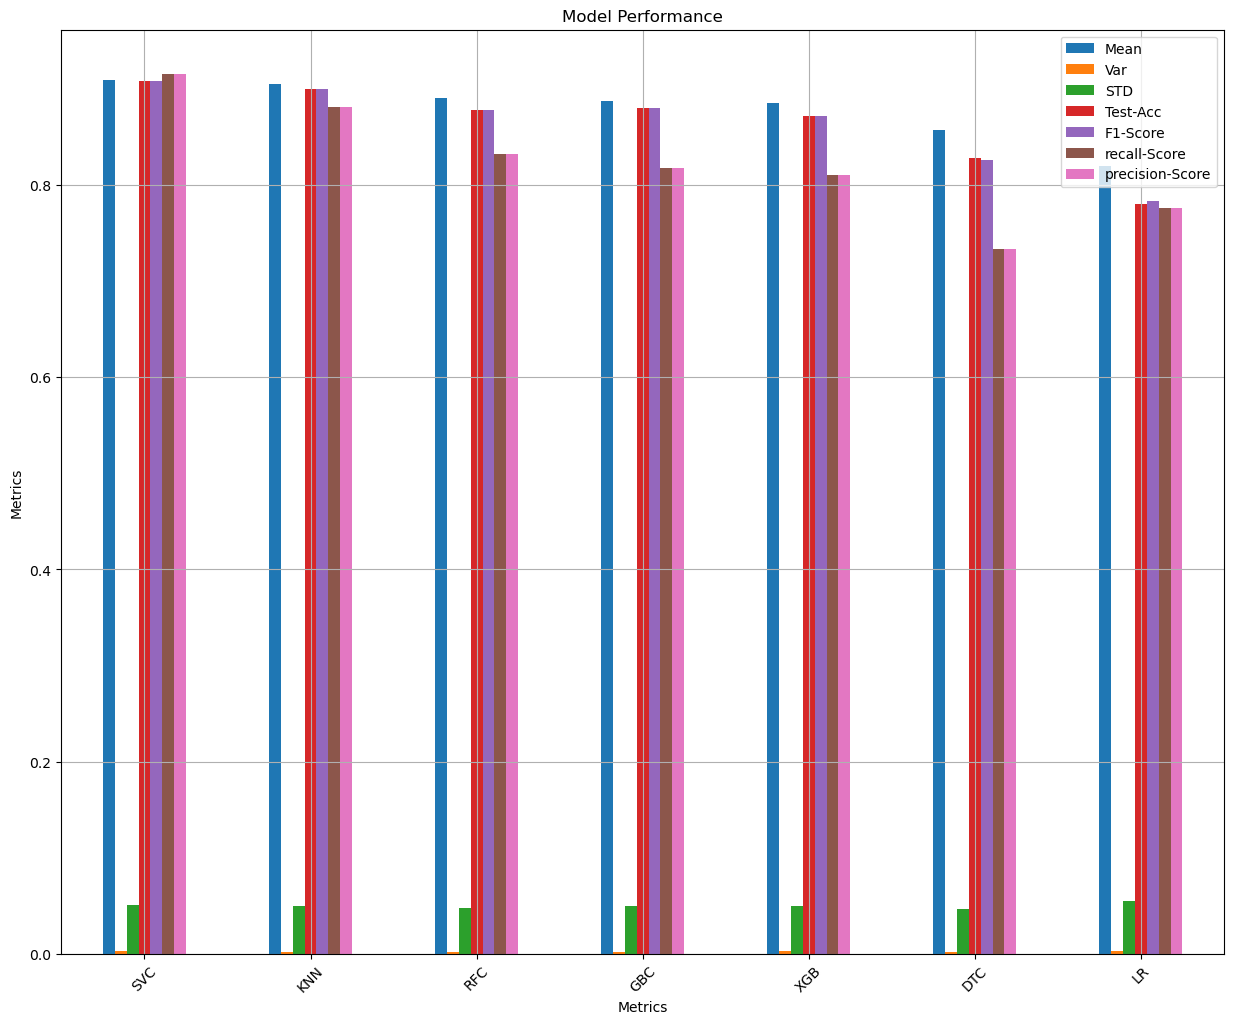

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      1   SVC  0.909  0.003  0.051     0.908     0.908         0.916   
1      2   KNN  0.905  0.002  0.050     0.900     0.900         0.881   
2      3   RFC  0.891  0.002  0.048     0.878     0.878         0.832   
3      6   GBC  0.888  0.002  0.050     0.880     0.880         0.818   
4      5   XGB  0.886  0.003  0.050     0.872     0.872         0.811   
5      4   DTC  0.857  0.002  0.047     0.828     0.826         0.734   
6      0    LR  0.820  0.003  0.055     0.780     0.783         0.776   

   precision-Score  
0            0.916  
1            0.881  
2            0.832  
3            0.818  
4            0.811  
5            0.734  
6            0.776  


In [51]:
model_names = ["LR", "SVC", "KNN", "RFC", "DTC", "XGB", "GBC"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, preprocessor, X, y, f1_metric)

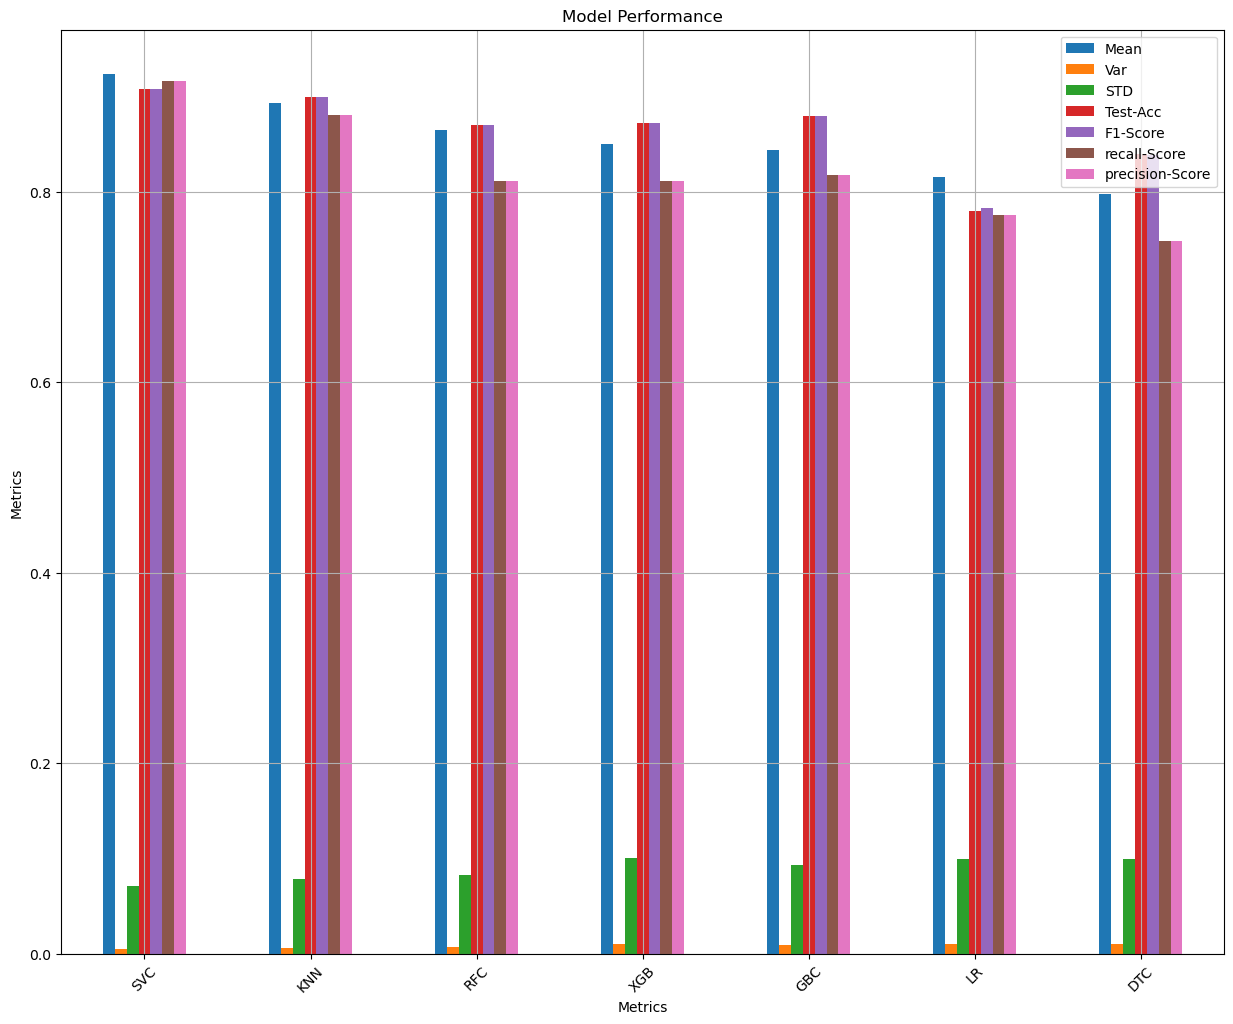

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      1   SVC  0.924  0.005  0.071     0.908     0.908         0.916   
1      2   KNN  0.893  0.006  0.078     0.900     0.900         0.881   
2      3   RFC  0.865  0.007  0.083     0.870     0.870         0.811   
3      5   XGB  0.850  0.010  0.101     0.872     0.872         0.811   
4      6   GBC  0.844  0.009  0.093     0.880     0.880         0.818   
5      0    LR  0.816  0.010  0.099     0.780     0.783         0.776   
6      4   DTC  0.798  0.010  0.099     0.840     0.839         0.748   

   precision-Score  
0            0.916  
1            0.881  
2            0.811  
3            0.811  
4            0.818  
5            0.776  
6            0.748  


In [52]:
model_names = ["LR", "SVC", "KNN", "RFC", "DTC", "XGB", "GBC"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, preprocessor, X, y, recall_metric)

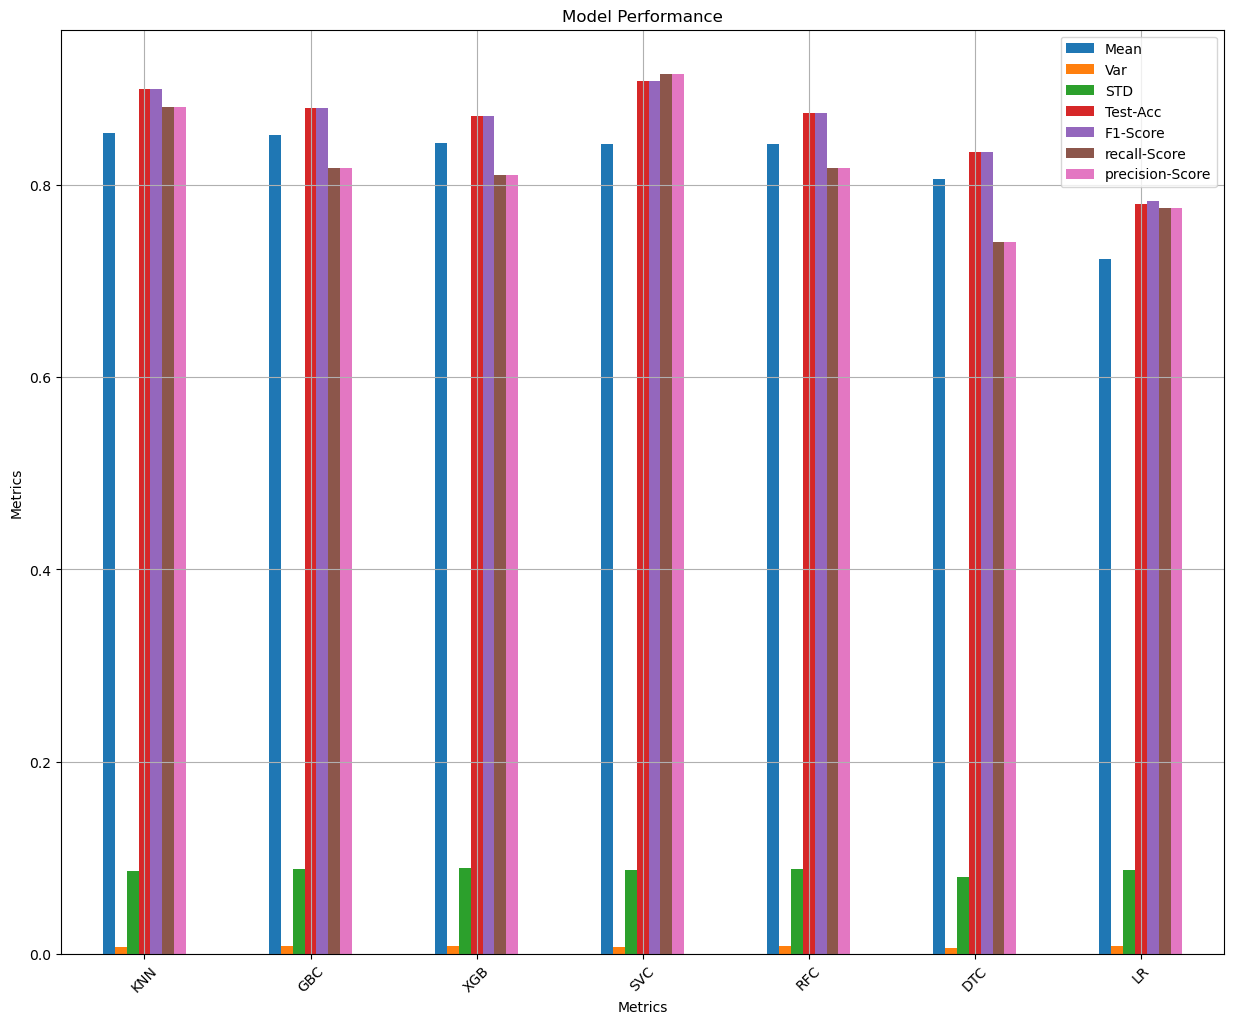

   index Model   Mean    Var    STD  Test-Acc  F1-Score  recall-Score  \
0      2   KNN  0.854  0.007  0.086     0.900     0.900         0.881   
1      6   GBC  0.852  0.008  0.088     0.880     0.880         0.818   
2      5   XGB  0.844  0.008  0.089     0.872     0.872         0.811   
3      1   SVC  0.843  0.007  0.087     0.908     0.908         0.916   
4      3   RFC  0.843  0.008  0.088     0.875     0.875         0.818   
5      4   DTC  0.806  0.006  0.080     0.835     0.834         0.741   
6      0    LR  0.723  0.008  0.087     0.780     0.783         0.776   

   precision-Score  
0            0.881  
1            0.818  
2            0.811  
3            0.916  
4            0.818  
5            0.741  
6            0.776  


In [53]:
model_names = ["LR", "SVC", "KNN", "RFC", "DTC", "XGB", "GBC"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, preprocessor, X, y, precision_metric)

# We tested a bunch of models on different metrics, given that this is an ad campaign and type II errors are not as consequential to our dataset. Preventing False positives might be the most important metric to follow given that we want to make sure that money spent on a customer we believe is in the interested category. A high precision rate means that the resources spent on contacting leads are not easted on those unlikely to convert.

# Let's incorporate some sampling models given that our dataset is unbalanced and then run further tests.